<a href="https://colab.research.google.com/github/ramana16/EVA4/blob/master/EVA4S15%5CS15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
%reload_ext autoreload
%autoreload 2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import zipfile

path_to_zip_file = "/content/gdrive/My Drive/Colab Notebooks/EVA4/S15/dataset.zip"
directory_to_extract_to = '/content/'
print("Extracting zip file: %s" % path_to_zip_file)
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  for f in zip_ref.namelist():
    if f.startswith(('bg/','fg_bg/','fg_bg_masks/','fg_bg_depth/')):
      zip_ref.extract(f, directory_to_extract_to)
print("Extracted at: %s" % directory_to_extract_to)

Extracting zip file: /content/gdrive/My Drive/Colab Notebooks/EVA4/S15/dataset.zip
Extracted at: /content/


In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4a1791d0-98c6-721f-feea-b64a21a2dfa1)


In [5]:
!rm -rf images
!mkdir images

In [51]:
!cd models;rm *.pth

rm: cannot remove '*.pth': No such file or directory


In [8]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S15/')
%reload_ext autoreload
%autoreload 2

Mounted at /content/gdrive/


In [6]:
!pip install albumentations==0.4.5
!pip install kornia

     |████████████████████████████████| 122kB 7.9MB/s 
     |████████████████████████████████| 634kB 7.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=a4bc0a89b29c3c66fb1cd5fea7d68281a625cdc31b2535f9da607172500b901e
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=e4e697b7d5c1e0b9048085d5b9ddb1fe1370cc8d58edb037db9f54528ff621d7
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 204kB 7.9MB

In [9]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from data.data_engine import DataEngine
from config import ModelConfig
from models.depth_and_mask_dnn import DNN
from train import train
from results import plot_images, plot_graph
from utils import *

In [10]:
def test(model, device, test_loader, test_losses, epoch=0, save_img=True):
    model.eval()
    test_loss = 0
    mask_loss = 0
    depth_loss = 0
    eval_m = [0,0,0,0]
    eval_d = [0,0,0,0]
    with torch.no_grad():
        for batch_idx, sample in enumerate(test_loader):
            bg = sample["bg"]
            fg_bg = sample["fg_bg"]
            fg_bg_mask = sample["fg_bg_mask"].to(device)
            fg_bg_depth = sample["fg_bg_depth"].to(device)
            inp = torch.cat([bg,fg_bg], dim=1)
            inp = inp.to(device)
            mask_pred, depth_pred = model(inp)
            # Calculate loss
            loss_mask, mstr = loss_mask_function(output=mask_pred, target=fg_bg_mask,
                                    w_depth=1.0, w_ssim=1.0, w_edge=1.0)
            loss_depth, dstr = loss_depth_function(output=depth_pred, target=fg_bg_depth,
                                    w_depth=1.0, w_ssim=1.0, w_edge=1.0)
            loss = loss_mask + loss_depth
            test_loss += loss.item()
            mask_loss += loss_mask.item()
            depth_loss += loss_depth.item()

            if (batch_idx+1)%500 == 0 and save_img:
                show_images(mask_pred.detach().cpu(), cols=4, denorm="fg_bg_mask",
                    fname=f"images/test_{epoch:03d}_{batch_idx:05d}_{loss.item():0.5f}_Mp.jpg")
                show_images(fg_bg_mask.detach().cpu(), cols=4, denorm="fg_bg_mask",
                    fname=f"images/test_{epoch:03d}_{batch_idx:05d}_{loss.item():0.5f}_Mt.jpg")
                show_images(depth_pred.detach().cpu(), cols=4, denorm="fg_bg_depth",
                    fname=f"images/test_{epoch:03d}_{batch_idx:05d}_{loss.item():0.5f}_Dp.jpg")
                show_images(fg_bg_depth.detach().cpu(), cols=4, denorm="fg_bg_depth",
                    fname=f"images/test_{epoch:03d}_{batch_idx:05d}_{loss.item():0.5f}_Dt.jpg")
                show_images(fg_bg.detach().cpu(), cols=4, denorm="fg_bg",
                    fname=f"images/test_{epoch:03d}_{batch_idx:05d}_{loss.item():0.5f}_B.jpg")

            pem = evaluate(fg_bg_mask, mask_pred)
            ped = evaluate(fg_bg_depth, depth_pred)
            for i in range(len(ped)):
                eval_m[i] += pem[i]
                eval_d[i] += ped[i]

    test_loss /= len(test_loader)
    mask_loss /= len(test_loader)
    depth_loss /= len(test_loader)
    test_losses.append(test_loss)
    eval_t = [0,0,0,0]
    for i in range(len(pem)):
        eval_m[i] /= len(test_loader)
        eval_d[i] /= len(test_loader)
        eval_t[i] = (eval_m[i]+eval_d[i])/2
    
    print('Test set: Average loss: {:.4f}, Average MaskLoss: {:.4f}, Average DepthLoss: {:.4f}\n'.format(
        test_loss, mask_loss, depth_loss))
    print("{}: {:>10}, {:>10}, {:>10}, {:>10}".format(
        "Metric",'t<1.25', 't<1.25^2', 't<1.25^3', 'rms'))
    print("{}: {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(
        "Mask  ",eval_m[0],eval_m[1],eval_m[2],eval_m[3]))
    print("{}: {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}".format(
        "Depth ",eval_d[0],eval_d[1],eval_d[2],eval_d[3]))
    print("{}: {:10.4f}, {:10.4f}, {:10.4f}, {:10.4f}\n".format(
        "Avg   ",eval_t[0],eval_t[1],eval_t[2],eval_t[3]))

def evaluate(gt, pred):
    rmse = torch.sqrt(torch.nn.MSELoss()(gt, pred))
    # abs_rel = torch.mean(torch.abs(gt - pred) / gt)
    
    # While calculating t<1.25, we want the ratio of pixels to within a threshold
    # like 1.25. But if the value of pixel is less than 0.1 then even though the
    # pixel values are close the ratio scale changes
    # For ex, 0.00001 and 0.000001 are very close and we want them to contribute
    # positively for our accuracy but the ratio is 10 which reduces the accuracy.
    # So we clamp the tensors to 0.1 and 1   
    gt = torch.clamp(gt, min=0.1, max=1)
    pred = torch.clamp(pred, min=0.1, max=1)

    thresh = torch.max((gt / pred), (pred / gt))

    a1 = (thresh < 1.25   ).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    return a1.item(), a2.item(), a3.item(), rmse.item()


In [11]:
# View model config
args = ModelConfig()
args.print_config()
print()
# Set seed
init_seed(args)

Model Parameters:
{ 'batch_size_cpu': 128,
  'batch_size_cuda': 16,
  'data_path': '/content/',
  'dropout': 0.2,
  'epochs': 3,
  'im_size': 224,
  'l1_decay': 0,
  'l2_decay': 0.0001,
  'lr': 0.001,
  'momentum': 0.9,
  'num_workers': 4,
  'seed': 1}

CUDA Available


Dimensions:
bg         : [3, 224, 224]
fg_bg      : [3, 224, 224]
fg_bg_mask : [1, 224, 224]
fg_bg_depth: [1, 224, 224] 



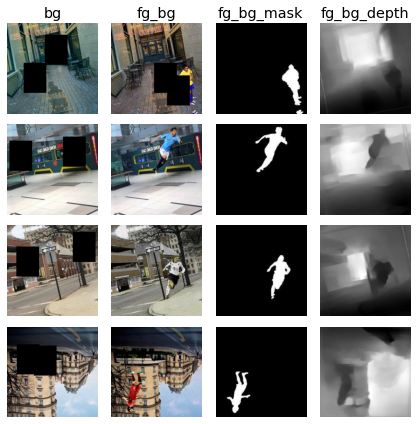

In [12]:
data = DataEngine(args)
data.show_samples()

In [13]:
device = which_device()
model = DNN(args.dropout).to(device)
show_model_summary(model, (6,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             864
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           9,216
       BatchNorm2d-4         [-1, 32, 224, 224]              64
            Conv2d-5         [-1, 32, 224, 224]           9,216
       BatchNorm2d-6         [-1, 32, 224, 224]              64
        BasicBlock-7         [-1, 32, 224, 224]               0
            Conv2d-8         [-1, 32, 224, 224]           9,216
       BatchNorm2d-9         [-1, 32, 224, 224]              64
           Conv2d-10         [-1, 32, 224, 224]           9,216
      BatchNorm2d-11         [-1, 32, 224, 224]              64
       BasicBlock-12         [-1, 32, 224, 224]               0
           Conv2d-13         [-1, 32, 224, 224]             864
      BatchNorm2d-14         [-1, 32, 2

In [16]:
model_path = "/content/models/saved_models/im128_l0.1473_rms0.0666_t0.8726.pth"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
import datetime

epochs = args.epochs
optimizer = torch.optim.Adam( model.parameters(), args.lr )
scheduler = StepLR(optimizer, step_size=1, gamma=0.3)

test_losses, train_losses = [], []
lr_trend = []
def run(l1_decay=0.0, l2_decay=0.0):
  for epoch in range(0, epochs):
    st = datetime.datetime.now()
    lr_trend.append(optimizer.param_groups[0]['lr'])
    print(f"EPOCH: {epoch+1} (LR: {lr_trend[-1]:0.6f})")
    train(model, device, data.train_loader, optimizer, epoch,
          l1_decay,l2_decay, train_losses)
    et_train = datetime.datetime.now()
    delta_train = et_train-st
    # scheduler.step()
    st_test = datetime.datetime.now()
    test(model, device, data.test_loader, test_losses, epoch, save_img=True)
    et = datetime.datetime.now()
    delta = et-st
    delta_test = et-st_test
    print(f"EPOCH: {epoch+1} processing time: {delta} [Train: {delta_train}] [Test: {delta_test}]")

# train and test the model
run(l1_decay=args.l1_decay, l2_decay=args.l2_decay)

  0%|          | 0/20000 [00:00<?, ?it/s]

EPOCH: 1 (LR: 0.001000)


L2_loss=430.465 Loss=0.26102 LossMask=0.03742[(d0.011,s0.019,e0.007)] LossDepth=0.180562[(d0.101,s0.070,e0.010)] Batch_id=4927:  25%|██▍       | 4927/20000 [1:10:53<3:35:05,  1.17it/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')